# QML Challenge

In questa sfida, i partecipanti svilupperanno un modello per prevedere i livelli di PM25 sulla base delle misurazioni di umidità e PM10. Questa sfida simula uno scenario reale in cui si vuole stimare il particolato fine (PM25) utilizzando parametri più facilmente misurabili.

In [1]:
%pip install seaborn pandas scikit-learn torch pennylane qbraid-core -q

import pandas as pd
import torch
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
# read in the data set

df = pd.read_csv('./particolato.csv',index_col=0, dtype={ "sensors.humidify": "int64", "sensors.pm10":"float64", "sensors.pm25":"float64"}, parse_dates=["Time"])




Note: you may need to restart the kernel to use updated packages.


In [2]:
# okay lets try doing some EDA on this 

df.dropna(inplace=True)
# Display the first few rows
print(df.head())

# Basic information about the dataset
print(df.info())

# Summary statistics
print(df.describe())

                     sensors.humidity  sensors.pm10  sensors.pm25
Time                                                             
2024-05-05 00:00:00              92.0           6.0           1.8
2024-05-05 01:00:00              97.0           4.5           1.8
2024-05-05 02:00:00              95.0           6.8           2.0
2024-05-05 03:00:00              96.0           4.1           1.6
2024-05-05 04:00:00              91.0           4.2           1.5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2024-05-05 00:00:00 to 2024-06-26 23:00:00
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sensors.humidity  1239 non-null   float64
 1   sensors.pm10      1239 non-null   float64
 2   sensors.pm25      1239 non-null   float64
dtypes: float64(3)
memory usage: 38.7 KB
None
       sensors.humidity  sensors.pm10  sensors.pm25
count       1239.000000   1239.000000   1239.000000
mean       

<Figure size 1200x800 with 0 Axes>

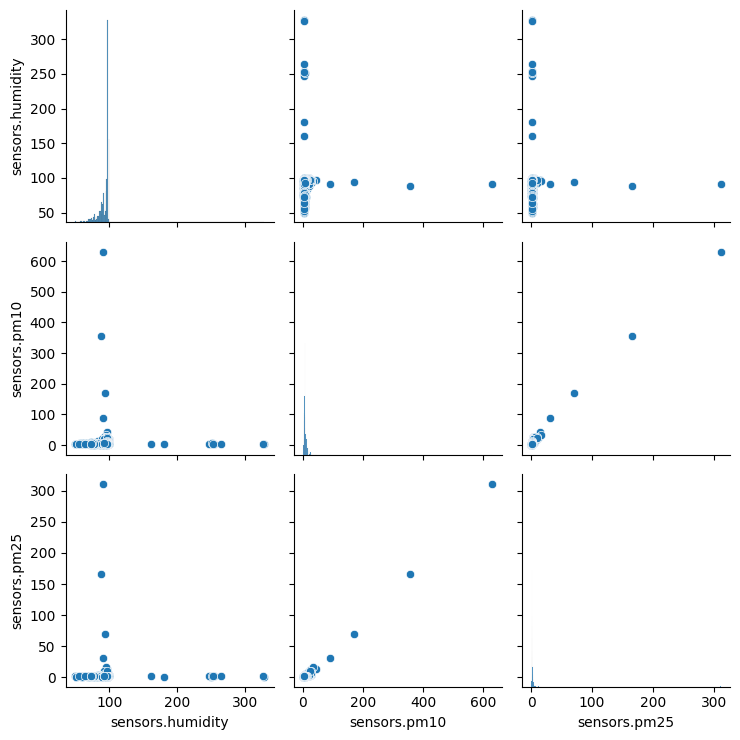

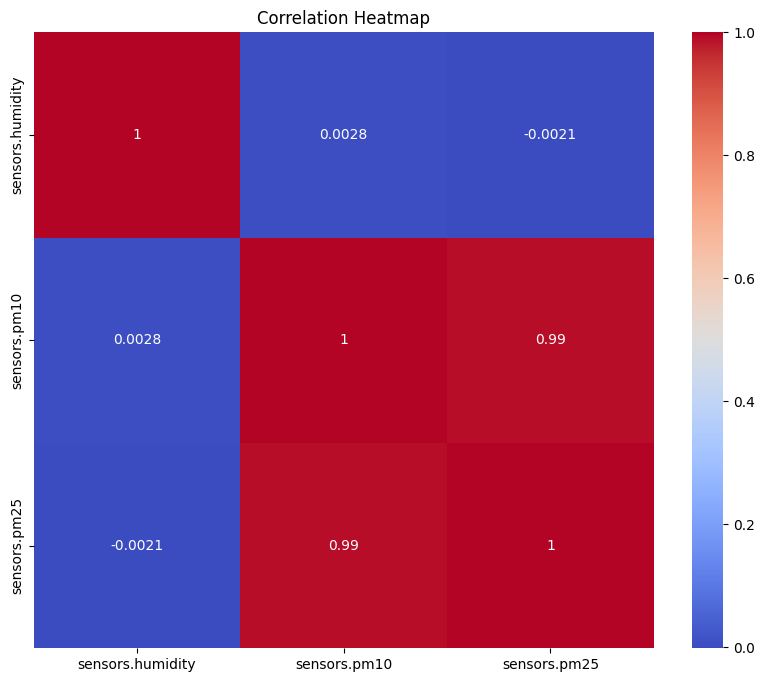

In [3]:
# EDA
plt.figure(figsize=(12, 8))
sns.pairplot(df[['sensors.humidity', 'sensors.pm10', 'sensors.pm25']])
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['sensors.humidity', 'sensors.pm10', 'sensors.pm25']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


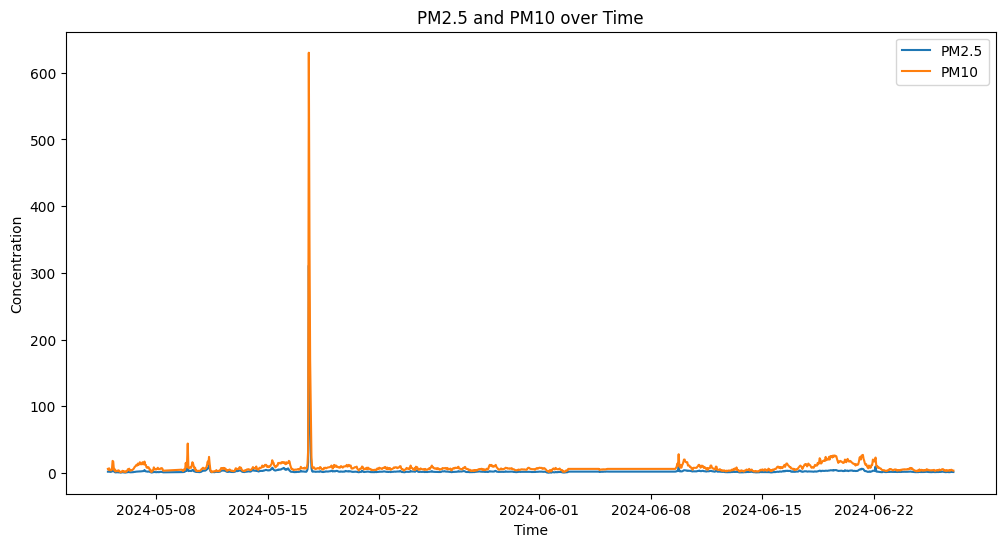

In [4]:
# Time series plot
plt.figure(figsize=(12, 6))
plt.plot( df['sensors.pm25'], label='PM2.5')
plt.plot( df['sensors.pm10'], label='PM10')
plt.title('PM2.5 and PM10 over Time')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()


In [5]:

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

In [6]:
import torch
# Split the data
X = df[['sensors.humidity', 'sensors.pm10', 'hour', 'day_of_week']]
y = df['sensors.pm25']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)


In [7]:
import pennylane as qml
import torch

# Set default tensor type to float32
torch.set_default_tensor_type(torch.FloatTensor)

# Define the quantum device
n_features = X_train.shape[1]
print(f"Number of features: {n_features}")

n_qubits = min(n_features, 10)  # Limit the number of qubits to a maximum of 10

# Define the quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

class HybridModel(torch.nn.Module):
    def __init__(self, n_features, n_qubits):
        super().__init__()
        self.n_features = n_features
        self.n_qubits = n_qubits
        self.pre_net = torch.nn.Linear(n_features, n_qubits)
        self.q_params = torch.nn.Parameter(torch.randn(3, n_qubits))
        self.post_net = torch.nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = self.pre_net(x)
        x = torch.stack([torch.tensor(quantum_circuit(x_i.unsqueeze(0) if x_i.dim() == 0 else x_i, self.q_params), dtype=torch.float32) for x_i in x])
        x = self.post_net(x)
        return x

# Initialize the model
model = HybridModel(n_features, n_qubits)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Ensure input data is float32
X_train_tensor = X_train_tensor.float()
y_train_tensor = y_train_tensor.float()
X_test_tensor = X_test_tensor.float()
y_test_tensor = y_test_tensor.float()

# Training loop
epochs = 10
batch_size = 32

for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

mae = mean_absolute_error(y_test, y_pred.numpy())
print(f"Mean Absolute Error: {mae:.4f}")

C:\Users\julie\miniconda3\envs\new_womanium\Lib\site-packages\torch\__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


Number of features: 4
Epoch [10/10], Train Loss: 0.5552, Val Loss: 272.0560
Mean Absolute Error: 1.7779


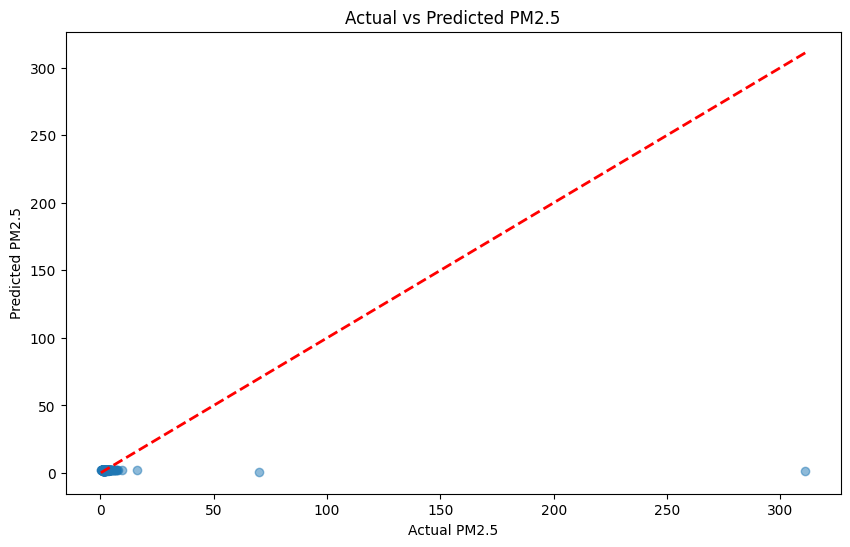

In [8]:

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.show()




In [9]:
torch.save(model.state_dict(), 'model_weights.pth')

In [10]:
model.load_state_dict(torch.load('model_weights.pth'))

C:\Users\julie\AppData\Local\Temp\ipykernel_14268\2178556627.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

In [11]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Scale the validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [12]:
def compute_accuracy(y_true, y_pred, threshold=0.5):
    correct = torch.abs(y_true - y_pred) < threshold
    return correct.float().mean().item()

In [13]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    val_accuracy = compute_accuracy(y_val_tensor, y_val_pred)
    
print(f"Validation Accuracy (threshold=0.5): {val_accuracy:.4f}")

Validation Accuracy (threshold=0.5): 0.4892


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

val_mae = mean_absolute_error(y_val, y_val_pred.numpy())
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred.numpy()))

print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

Validation MAE: 1.0832
Validation RMSE: 5.2262


In [15]:
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    test_accuracy = compute_accuracy(y_test_tensor, y_test_pred)
    
test_mae = mean_absolute_error(y_test, y_test_pred.numpy())
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred.numpy()))

print(f"Test Accuracy (threshold=0.5): {test_accuracy:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test Accuracy (threshold=0.5): 0.4624
Test MAE: 2.4727
Test RMSE: 22.7332


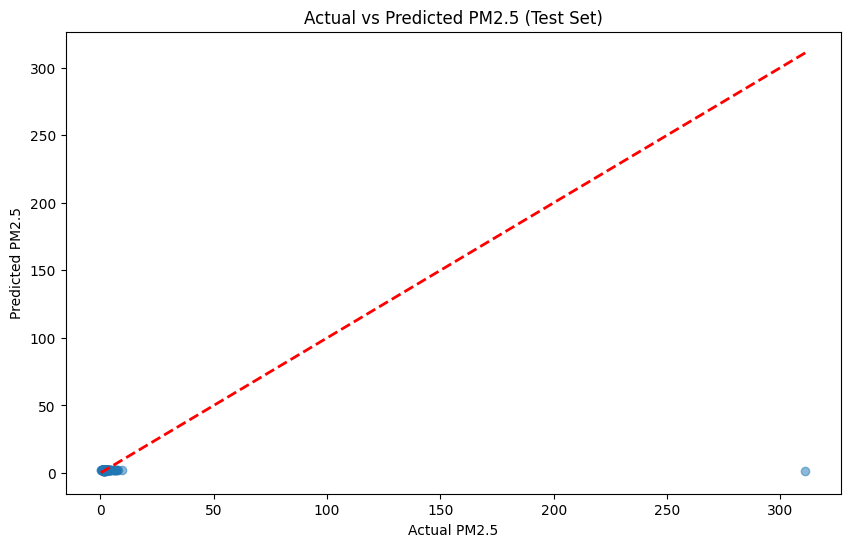

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred.numpy(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (Test Set)')
plt.show()

## Sottomissione della sfida per ottenere il punteggio

Abbiamo integrato il sistema di punteggio nella piattaforma qBraid. Per inviare il vostro modello, dovrete prima inizializzare una sessione qBraid e configurare il client IonQ/SCQ.

In [ ]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

Ora arriva la parte più eccitante! Usare il metodo `submit_model_for_grading` del classificatore per sottomettere il modello alla valutazione.

Il quantum layer e i pesi addestrati saranno serializzati e poi riassemblati in un ambiente sicuro. Verrà eseguita un'inferenza su un set di validazione non visibile, utilizzando il modello ricostruito per calcolare l'accuracy score.

In [ ]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

L'elaborazione dei risultati potrebbe richiedere del tempo.

In [ ]:
client.await_autograder_result(submission_id=submission_id)


Dopo qualche minuto, controllate [la classifica in tempo reale](https://account.qbraid.com/hackathons/2024/crs4) per vedere come si classifica il vostro team!

🍀 In bocca al lupo! Speriamo che tu ti diverta a cimentarti in questa sfida .🤞 🥳 🎉


# 👉 [La classifica in tempo reale](https://account.qbraid.com/hackathons/2024/crs4)

Visitate il link qua sopra per vedere che punteggio avete ottenuto.